In [1]:
from stage1 import *

In [2]:
nframes,natoms,nmols=(0,0,0)

In [3]:
from stage2_4 import * 

In [4]:
stage1

VGAE(
  (encoder): VariationalGCNEncoder(
    (conv1): GATConv(5, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(16, 3, bias=True)
    (mu): Linear(3, 3, bias=True)
    (logstd): Linear(3, 3, bias=True)
  )
  (decoder): VariationalGCNDecoder(
    (inv_transform): Linear(3, 4, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 5, bias=True)
  )
)

In [5]:
testframe=md.load_xtc("../../xtc_files/50000eql2.xtc",top="../../xtc_files/conf.gro",frame=0)


In [6]:
cf=condenseframe(testframe)

In [7]:
meltframes=md.load_xtc("../../xtc_files/50000eql2.xtc",top="../../xtc_files/conf.gro")
meltframes.xyz=meltframes.xyz*10
global nframes,natoms,nmols 
nframes = meltframes.xyz.shape[0]
natoms = meltframes.topology.residue(0).n_atoms
nmols = meltframes.topology.n_residues
print (nframes,natoms,nmols)
meltframes=meltframes[::1000]

50001 4 592


In [8]:
cf

array([[ 7.84576243e+02, -9.36140506e+01, -1.56635818e+02,
         2.28225017e+00,  9.52250063e-01,  1.95350003e+00],
       [ 7.79803099e+02, -9.30955292e+01, -1.55628271e+02,
         1.36549997e+00,  1.45650005e+00,  2.59900022e+00],
       [ 8.75985383e+02, -1.05724399e+02, -1.74737958e+02,
         8.33750010e-01,  1.77175009e+00,  7.37500072e-01],
       ...,
       [ 7.41200941e+02, -8.83453476e+01, -1.47991849e+02,
         2.56474996e+00,  1.57500005e+00,  2.47574997e+00],
       [ 7.57661722e+02, -9.03470056e+01, -1.51268077e+02,
         1.61825013e+00,  1.92200017e+00,  2.49900007e+00],
       [ 8.03441321e+02, -9.64539095e+01, -1.60332419e+02,
         7.91500092e-01,  2.24175000e+00,  2.16525006e+00]])

In [9]:
melt_condensed=condenseAllFrames(meltframes)
graphs_melt_cpu=get_graphs(melt_condensed,"melt")
print(len(graphs_melt_cpu))

100%|██████████| 51/51 [00:01<00:00, 29.06it/s]

30192


In [10]:
torch.save(graphs_melt_cpu,f'./graphs/melt_neigh{n_neigh}.pt')

In [11]:
g = get_graph(cf,1,n_neigh,"cry")

In [12]:
graphs_cpu=graphs_melt_cpu
np.random.shuffle(graphs_cpu)


In [13]:
import os
in_channels = graphs_cpu[0].num_features
out_channels = 5
lr = 1e-4
n_epochs = 20
batch_size=32
test_train_split = 0.8
model_name = "Interex1.pt"
model_loaded = False
force_train = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if os.path.exists("./"+model_name) and not force_train:
    model = torch.load("./"+model_name)
    model_loaded = True
else:
    model = VGAE_S2(VariationalGCNEncoder_S2(in_channels, out_channels,batch_size,n_neigh+1),
                    VariationalGCNDecoder_S2(out_channels, in_channels,batch_size,n_neigh+1))

model = model.to(device)
model = model.double()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.5)


In [14]:
graphs_device = []
for graph in tqdm(graphs_cpu):
    graphs_device.append(graph.to(device))

100%|██████████| 30192/30192 [00:20<00:00, 1484.34it/s]


In [15]:
graphs = graphs_device
total_graphs = len(graphs)


In [16]:
print("Using:",device )
print("total_graphs:", total_graphs)
print("batch Size:" , batch_size)
print("number of batches:",total_graphs//batch_size)
print("Neighbours:",n_neigh)
print("Model\n",model)

Using: cuda
total_graphs: 30192
batch Size: 32
number of batches: 943
Neighbours: 20
Model
 VGAE_S2(
  (encoder): VariationalGCNEncoder_S2(
    (conv1): GATConv(6, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(84, 5, bias=True)
    (mu): Linear(5, 5, bias=True)
    (logstd): Linear(5, 5, bias=True)
  )
  (decoder): VariationalGCNDecoder_S2(
    (inv_transform): Linear(5, 21, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 6, bias=True)
  )
)


In [17]:
split = int(test_train_split * total_graphs)
train_loader = DataLoader(graphs[:split], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(graphs[split:], batch_size=batch_size, shuffle=True)

In [18]:
cross_entropy_loss = torch.nn.CrossEntropyLoss()
MSE_loss = torch.nn.MSELoss()

def train():
    model.train()
    model.zero_grad()
    all_loss_mse = 0
    for data in train_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        loss = MSE_loss(decoded_x, data.x)
        loss.backward()
        all_loss_mse += float(loss)
        optimizer.step()


    return all_loss_mse/len(train_loader)

In [19]:
def test():
    model.eval()
    model.zero_grad()
    all_loss_mse = 0
    for data in test_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)

        loss = MSE_loss(decoded_x, data.x)

        all_loss_mse += float(loss)


    return all_loss_mse/len(test_loader)

In [20]:
train_losses = []
test_losses = []

if model_loaded:
    print("Pretrained Model Loaded, no training required")
else:
    for epoch in range(1, n_epochs + 1):

        train_loss_mse = train()
        test_loss_mse = test()

        print(f"Epoch: {epoch:03d}")
        print(f'\tTrain:\tMSE Loss: {train_loss_mse:.4f}')
        print(f'\tTest: \tMSE Loss: {test_loss_mse:.4f}')

        train_losses.append([train_loss_mse]);
        test_losses.append([test_loss_mse]);

        scheduler.step()
    torch.save(model,"./models/"+model_name)

Epoch: 001
	Train:	MSE Loss: 3424.6501
	Test: 	MSE Loss: 2793.6270
Epoch: 002
	Train:	MSE Loss: 2340.1887
	Test: 	MSE Loss: 1991.8900
Epoch: 003
	Train:	MSE Loss: 1852.4148
	Test: 	MSE Loss: 1526.8181
Epoch: 004
	Train:	MSE Loss: 1430.4118
	Test: 	MSE Loss: 1201.0215
Epoch: 005
	Train:	MSE Loss: 1230.9399
	Test: 	MSE Loss: 1096.2266
Epoch: 006
	Train:	MSE Loss: 1131.4429
	Test: 	MSE Loss: 1043.8035
Epoch: 007
	Train:	MSE Loss: 1066.1284
	Test: 	MSE Loss: 1002.4819
Epoch: 008
	Train:	MSE Loss: 1010.6027
	Test: 	MSE Loss: 951.9692
Epoch: 009
	Train:	MSE Loss: 952.6466
	Test: 	MSE Loss: 907.0288
Epoch: 010
	Train:	MSE Loss: 900.4783
	Test: 	MSE Loss: 860.4881
Epoch: 011
	Train:	MSE Loss: 867.5845
	Test: 	MSE Loss: 846.3398
Epoch: 012
	Train:	MSE Loss: 841.6874
	Test: 	MSE Loss: 807.3944
Epoch: 013
	Train:	MSE Loss: 822.2108
	Test: 	MSE Loss: 803.6472
Epoch: 014
	Train:	MSE Loss: 804.6670
	Test: 	MSE Loss: 778.9520
Epoch: 015
	Train:	MSE Loss: 785.4353
	Test: 	MSE Loss: 774.8042
Epoch: 016

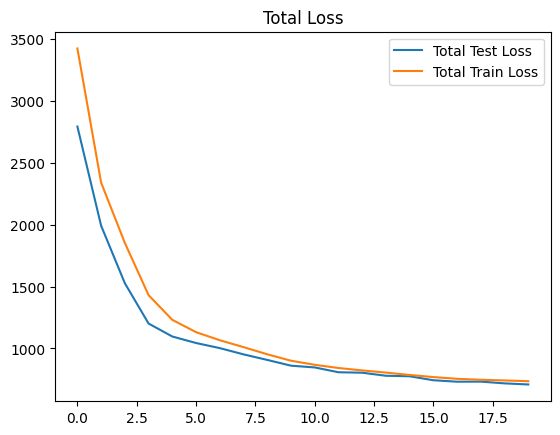

In [21]:
if not model_loaded:
    plt.figure()
    plt.plot(test_losses, label='Total Test Loss')
    plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

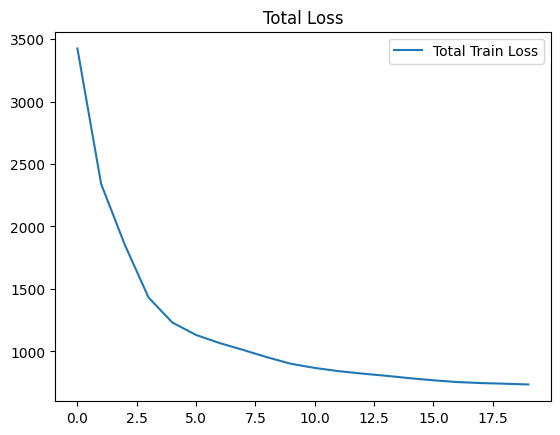

In [22]:
if not model_loaded:
    plt.figure()
    # plt.plot(test_losses, label='Total Test Loss')
    plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

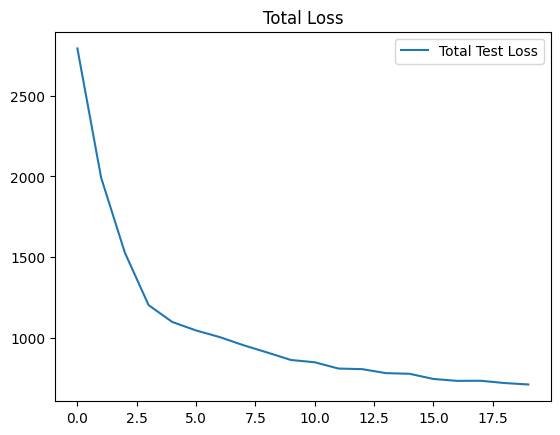

In [23]:
if not model_loaded:
    plt.figure()
    plt.plot(test_losses, label='Total Test Loss')
    # plt.plot(train_losses, label='Total Train Loss')
    plt.legend()
    plt.title('Total Loss')
    plt.show()

In [24]:
from torch.functional import F

avg1 = 0
avg2 = 0

embeddings = []
input_feature = []
decoded_feature = []

for ind in range(len(test_loader)):
    test_graph = test_loader.dataset[ind]

    model.double()
    z,encoded_edge_index = model.encode(test_graph.x,test_graph.edge_index)
    decoded_x,decoded_edge_index = model.decode(z,encoded_edge_index)
    heavy_indices = torch.where(test_graph.x[:,4] > torch.tensor([1]).to(device))

    embeddings.append(z)
    decoded_feature.append(decoded_x)
    input_feature.append(test_graph.x)
    
    Error_wo_s = F.mse_loss(decoded_x[heavy_indices], test_graph.x[heavy_indices]).detach().cpu().numpy()



    avg1 += Error_wo_s

print("Average Error", avg1/len(test_loader))


Average Error 623.0979153286606


In [25]:
np.set_printoptions(suppress=True)
heavy_indices = torch.where(input_feature[0][:,4] > torch.tensor([1]).to(device))
heavy_indices
# decoded_feature[0][heavy_indices],input_feature[0][heavy_indices]
len(input_feature[0][heavy_indices])

21

In [26]:
decoded_feature[0][heavy_indices]

tensor([[-7.0270e-01, -5.1533e-03, -4.0549e-02,  1.5692e+01,  1.6336e+01,
          1.5910e+01],
        [-3.3266e-01, -1.3623e+00, -2.5384e+00,  1.5764e+01,  1.6189e+01,
          1.5577e+01],
        [-3.2982e-01, -1.3795e+00, -2.5635e+00,  1.5747e+01,  1.6169e+01,
          1.5561e+01],
        [-3.2778e-01, -1.3919e+00, -2.5816e+00,  1.5734e+01,  1.6154e+01,
          1.5549e+01],
        [-3.3136e-01, -1.3701e+00, -2.5499e+00,  1.5756e+01,  1.6180e+01,
          1.5570e+01],
        [-3.2706e-01, -1.3962e+00, -2.5879e+00,  1.5730e+01,  1.6148e+01,
          1.5545e+01],
        [-3.2808e-01, -1.3900e+00, -2.5789e+00,  1.5736e+01,  1.6156e+01,
          1.5551e+01],
        [-3.3051e-01, -1.3753e+00, -2.5574e+00,  1.5751e+01,  1.6174e+01,
          1.5565e+01],
        [-3.2533e-01, -1.4067e+00, -2.6032e+00,  1.5719e+01,  1.6136e+01,
          1.5535e+01],
        [-3.2451e-01, -1.4117e+00, -2.6105e+00,  1.5714e+01,  1.6130e+01,
          1.5531e+01],
        [-3.2647e-01, -1.3998e

In [27]:
input_feature[0][heavy_indices]

tensor([[-3.4897,  0.5889, -0.2991, 21.1100, 11.2875, 10.5125],
        [-3.3335,  0.6064, -0.2987, 20.4900,  9.7775, 12.6300],
        [-3.1675,  0.6254, -0.3019, 18.7825, 12.6125, 10.2875],
        [-4.2051,  0.5135, -0.2870, 23.8025, 11.2600, 10.7800],
        [-2.2848,  0.7253, -0.3005, 20.2750, 10.9850,  7.7850],
        [-4.7421,  0.4572, -0.2845, 21.8075, 14.5975, 11.0025],
        [-4.9032,  0.4401, -0.2808, 22.1950, 13.0750, 13.3375],
        [-1.3238,  0.8351, -0.2967, 19.7350,  8.4350,  8.6550],
        [-3.9239,  0.5466, -0.2882, 22.3025, 13.8675,  8.1700],
        [-4.0093,  0.5351, -0.2880, 19.4400, 12.1325, 13.7600],
        [-2.1710,  0.7380, -0.2956, 22.3175,  7.3525,  9.8650],
        [-4.3239,  0.4995, -0.2938, 19.0750, 15.0350, 11.3200],
        [-4.2971,  0.5072, -0.2837, 24.7825, 12.6825,  8.6425],
        [-3.3497,  0.6094, -0.2920, 19.3425, 14.6500,  8.2525],
        [-2.9929,  0.6468, -0.2971, 22.5725,  7.3950, 12.5650],
        [-5.3280,  0.3922, -0.2815, 24.6

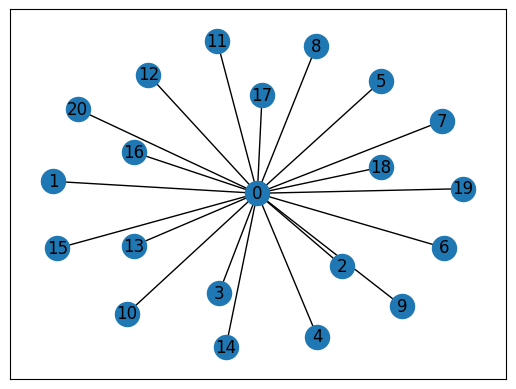

In [28]:
add_self_loops=False
adj_binary = convert_to_adj(decoded_edge_index, num_nodes=decoded_x.shape[0])
indices = torch.where(adj_binary)
G = nx.Graph()
if not add_self_loops:
    edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
    G.add_edges_from(edges)
else:
    G.add_edges_from(zip(indices[0].tolist(), indices[1].tolist()))
nx.draw_networkx(G)
plt.show()
